<a href="https://colab.research.google.com/github/MonikSense/Diabetes/blob/main/diabetesv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (100000, 9)
Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

✅ Target column detected as: diabetes

🔹 Logistic Regression
Accuracy: 0.96
AUC: 0.962
Confusion Matrix:
 [[18122   178]


/tmp/ipython-input-4107386799.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_df.index, y=acc_df['Accuracy'], palette='viridis')


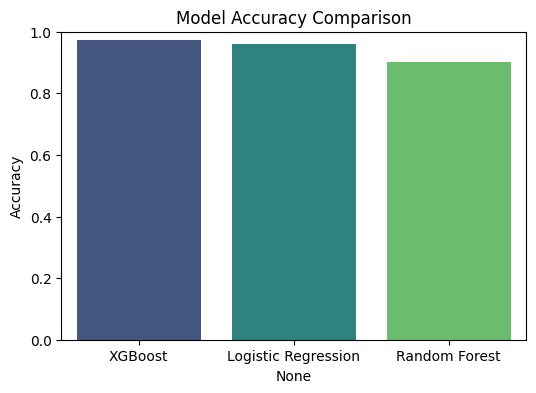

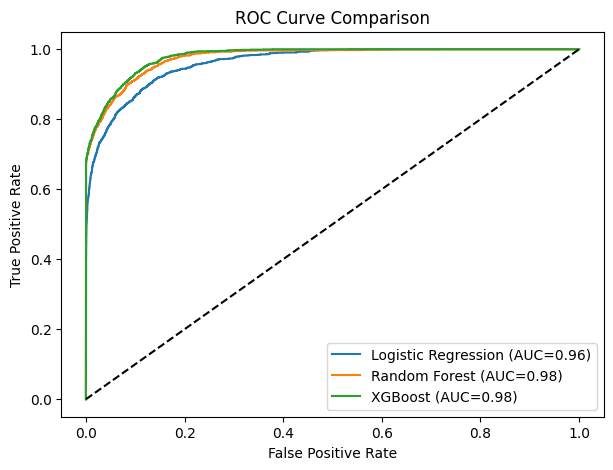

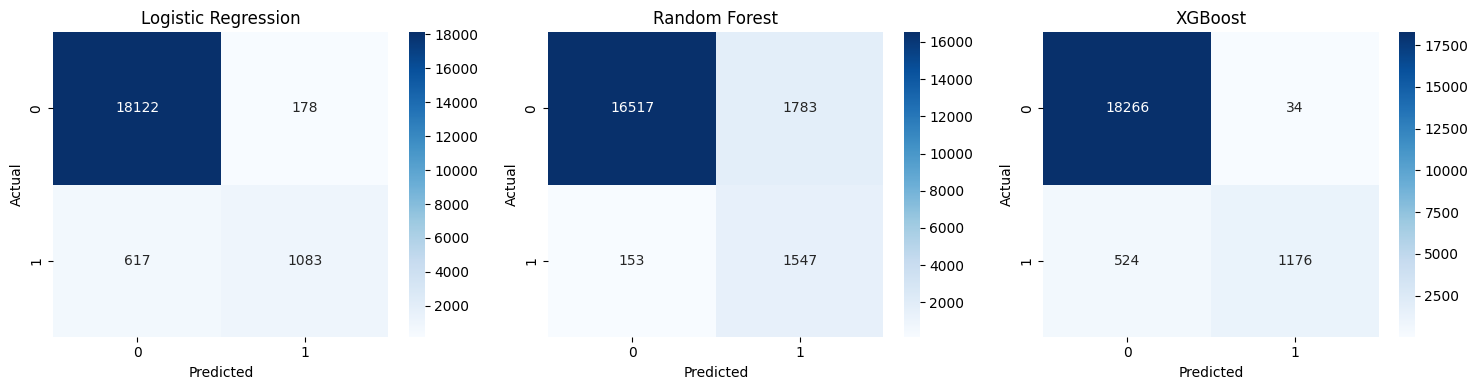

In [1]:
# ============================
# Diabetes Prediction using ML
# ============================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 2️⃣ Load Dataset
df = pd.read_csv("https://raw.githubusercontent.com/MonikSense/Diabetes/refs/heads/main/diabetes_prediction_dataset.csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 3️⃣ Try to detect target column
possible_targets = ["diabetes"]
target_col = None
for col in df.columns:
    if col.strip().capitalize() in [p.capitalize() for p in possible_targets]:
        target_col = col
        break

if target_col is None:
    print("\n⚠️ Target column not automatically found!")
    print("Please manually set the target column name below from these columns:")
    print(df.columns.tolist())
    raise ValueError("Set your target column name manually here before rerunning.")

print(f"\n✅ Target column detected as: {target_col}")

# 4️⃣ Define Features and Target
X = df.drop(columns=[target_col])
y = df[target_col]

# 5️⃣ Handle Missing Values (numeric → median, categorical → mode)
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# 6️⃣ Encode categorical variables
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# 7️⃣ Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8️⃣ Feature Scaling (for LR and XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 9️⃣ Model Training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs', C=1.0), #penalty: 'l1' (Lasso), 'l2' (Ridge), 'elasticnet' ,C: regularization strength (smaller → stronger penalty), solver: optimization algorithm (e.g., 'liblinear' good for small datasets)
    "Random Forest": RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
),
    "XGBoost": XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    eval_metric='auc'
)
}

results = {}

for name, model in models.items():
    if name == "Random Forest":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {"accuracy": acc, "auc": auc, "confusion": cm}

    print(f"\n🔹 {name}")
    print("Accuracy:", round(acc, 3))
    print("AUC:", round(auc, 3))
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred))

# 🔟 Compare Accuracy
acc_df = pd.DataFrame({m: results[m]["accuracy"] for m in results}, index=["Accuracy"]).T
acc_df.sort_values(by="Accuracy", ascending=False, inplace=True)

plt.figure(figsize=(6,4))
sns.barplot(x=acc_df.index, y=acc_df['Accuracy'], palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()

# 11️⃣ ROC Curves
plt.figure(figsize=(7,5))
for name, model in models.items():
    if name == "Random Forest":
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['auc']:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# 12️⃣ Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["confusion"], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()
